In [1]:
import numpy as np
from numpy.typing import ArrayLike, NDArray
from matplotlib.patches import Circle
from matplotlib import pyplot as plt

In [2]:
def draw(x_bed: NDArray,
         y_bed: NDArray,
         x_circles: NDArray,
         y_circles: NDArray,
         radii: NDArray,
         bead_colors=None,
         circle_kw=dict(),
         show_bed=True,
         label=None,
         scatter_centers=False):
    """Plotting the bed and the pile of circles."""
    fig, ax = plt.subplots()

    # Drawing the bed
    ymin = y_bed.min()-(y_bed.max()-y_bed.min())/2
    if show_bed:
        plt.fill_between(x_bed, y_bed, ymin, alpha=0.8)

    # Initialising beads colors and labels
    if isinstance(bead_colors, str) or bead_colors is None:
        bead_colors = [bead_colors]*radii.size
    if isinstance(label, str) or label is None:
        label = [label]*radii.size

    # Plot all circles
    for xc, yc, r, c, l in zip(x_circles, y_circles, radii, bead_colors, label, strict=True):
        circle_kw["label"] = l 
        ax.add_patch(Circle((xc, yc), r, color=c, **circle_kw))

    if scatter_centers:
        ax.scatter(x_circles, y_circles)
    ax.set_aspect("equal")
    ax.relim()
    ax.autoscale_view()
    return fig, ax

def random_range(vmin: float, vmax: float, N: int) -> NDArray:
    return vmin + (vmax-vmin)*np.random.random(N)

def base_layer(x_bed: NDArray,
               y_bed: NDArray,
               nx: NDArray,
               ny: NDArray,
               radii: NDArray,
               distances: NDArray=None,
               xp: float=None):
    """
    From the bed and its normal vectors' components, settle a first layer 
    of circles with the specified radii and approximte distances.
    """
    # Initialize the previous values
    xp = xp or x_bed[0]
    rp = radii[0]
    yp = np.interp(xp, x_bed, y_bed)+rp*ny[0]
    xp = xp + rp*nx[0]
    x_circles = [xp]
    y_circles = [yp]

    if distances is None:
        distances = random_range(0, 0, radii.size)

    for r, d in zip(radii[1:], distances[1:], strict=True):
        # Candidate circles are tangent to the bed
        xc = x_bed + nx*r
        yc = y_bed + ny*r
        # Compute the distance between each candidate and the previous circle
        dp = np.abs(np.sqrt((xp-xc)**2+(yp-yc)**2) - d)
        # There must be no overlay and the new circle should be on the right
        mask = (dp<r+rp) | (xc<xp)
        # Find the circle whose distance to the previous is the closest to `d`
        j = np.where(mask, np.inf, dp).argmin()
        # Reinitialize problem
        xp = xc[j]
        yp = yc[j]
        rp = r
        # Add circle to the list
        x_circles.append(xp)
        y_circles.append(yp)
    return np.array(x_circles), np.array(y_circles)

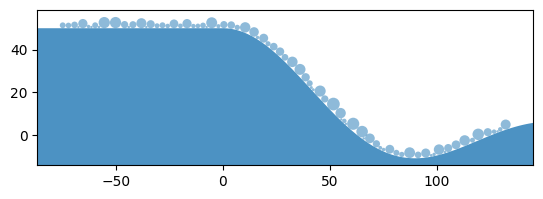

In [3]:
N0 = 80
Rmin = 0.5
Rmax = 3
avg_distance = Rmax-Rmin

# rayon et distance entre les billes aléatoires
radii_base = random_range(Rmin, Rmax, N0)

# Forme du fond
x_bed = np.linspace(1e-3, 2*N0*2*Rmax, num=1000*N0)-100
y_bed = 1000*np.sin(0.05*x_bed)/x_bed
y_bed[x_bed<0] = y_bed.max()
# Calcul de la normale au lit
angle = np.arctan((y_bed[2:]-y_bed[:-2])/(x_bed[2:]-x_bed[:-2]))
angle = np.hstack((np.arctan((y_bed[1]-y_bed[0])/(x_bed[1]-x_bed[0])),
                    angle,
                    np.arctan((y_bed[-1]-y_bed[-2])/(x_bed[-1]-x_bed[-2]))))
ny = +np.cos(angle)
nx = -np.sin(angle)

x_base, y_base = base_layer(x_bed, y_bed, nx, ny, radii_base, xp=-75)

draw(x_bed, y_bed, x_base, y_base, radii_base, circle_kw=dict(alpha=0.5))
plt.show()

In [4]:
def find_position(xp, yp, rp, rc, xn, yn, rn):
    a = rp + rc
    c = rc + rn
    b = np.sqrt((xn-xp)**2 + (yn-yp)**2)
    b = np.where(np.isclose(b, 0), np.nan, b)

    cos = (a**2 + b**2 - c**2) / (2*a*b)
    m = (-1 < cos) & (cos < 1)
    theta = np.arccos(np.where(m, cos, np.nan))
    beta = np.arccos((xn - xp)/b)

    beta[yp > yn] *= - 1

    xc1 = xp + a*np.cos(beta + theta)
    yc1 = yp + a*np.sin(beta + theta)
    xc2 = xp + a*np.cos(beta - theta)
    yc2 = yp + a*np.sin(beta - theta)
    return xc1, yc1, xc2, yc2

def is_positive_linear_combination(x, y, z):
    a = (z[0]*y[1] - z[1]*y[0]) / (x[0]*y[1] - x[1]*y[0])
    b = (z[0]*x[1] - z[1]*x[0]) / (y[0]*x[1] - y[1]*x[0])
    return (a > 0) & (b > 0)

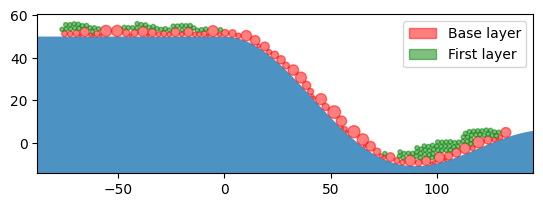

In [5]:
def add_layer(x_circles: NDArray,
              y_circles: NDArray,
              radii: NDArray,
              new_radii: NDArray,
              alpha_F: float=-np.pi/2,
              overlap_rtol: float=0.99):
    """From a given bed and a given pile of circles, lay a new layer of circles (new_radii) above it."""
    i = -1  # TODO
    for r in new_radii:  # For each circle of radius `r`

        m1 = m2 = np.full((1,), False)

        while m1.sum() + m2.sum() == 0 and i<radii.size-1:  # Loop until a good spot is found for the current circle
            i += 1

            # Reference circle
            xp = x_circles[i]
            yp = y_circles[i]
            rp = radii[i]

            # 1. Compute the two possible circles
            xc1, yc1, xc2, yc2 = find_position(xp, yp, rp, r, x_circles, y_circles, radii)

            # 2. Check they do not overlap with other circles
            m1 = ((xc1[None, :] - x_circles[:, None])**2 + (yc1[None, :] - y_circles[:, None])**2 >= overlap_rtol*(r+radii)[:, None]**2).all(axis=0)
            m2 = ((xc2[None, :] - x_circles[:, None])**2 + (yc2[None, :] - y_circles[:, None])**2 >= overlap_rtol*(r+radii)[:, None]**2).all(axis=0)

            # Check they oppose the force
            c = np.cos(alpha_F)
            s = np.sin(alpha_F)
            f1 = is_positive_linear_combination(
                np.array(((xc1 -        xp), (yc1 -        yp))),
                np.array(((xc1 - x_circles), (yc1 - y_circles))),
                np.array((-c, -s)),
            )
            f2 = is_positive_linear_combination(
                np.array(((xc2 -        xp), (yc2 -        yp))),
                np.array(((xc2 - x_circles), (yc2 - y_circles))),
                np.array((-c, -s)),
            )

            m1 = m1 & f1
            m2 = m2 & f2

        j1 = np.where(m1, yc1, np.inf).argmin()  # Find the lowest candidate circle
        j2 = np.where(m2, yc2, np.inf).argmin()  # Find the lowest candidate circle
        add_one = True
        if m1.any() and m2.any():
            if yc1[j1] < yc2[j2]:
                xc = xc1[j1]
                yc = yc1[j1]
            else:
                xc = xc2[j2]
                yc = yc2[j2]
        elif m1.any():
            xc = xc1[j1]
            yc = yc1[j1]
        elif m2.any():
            xc = xc2[j2]
            yc = yc2[j2]
        else:
            add_one = False

        if add_one:
            # And add it to the list
            x_circles = np.hstack((x_circles, xc))
            y_circles = np.hstack((y_circles, yc))
            radii = np.hstack((radii, r))

    return x_circles, y_circles, radii


N1 = 100
new_radii = random_range(1, 1, N1)
x_circles, y_circles, radii = add_layer(x_base, y_base, radii_base, new_radii, alpha_F=-np.pi/4*0.8)

draw(x_bed, y_bed, x_circles, y_circles, radii,
     bead_colors=["r"]*N0 + ["g"]*(x_circles.size-N0),
     label=["Base layer"]*N0 + ["First layer"]*(x_circles.size-N0),
     circle_kw=dict(alpha=0.5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")
plt.savefig("colored.pdf")
plt.show()

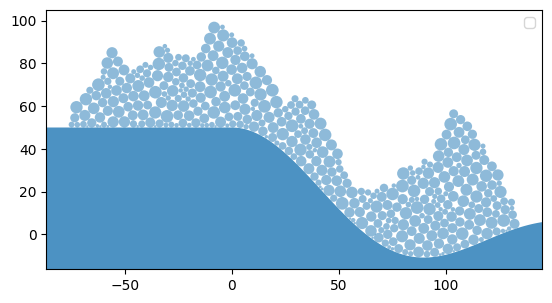

In [6]:
N2 = 80
new_radii = random_range(2, 3, N2)
x_circles, y_circles, radii = add_layer(x_base, y_base, radii_base, new_radii)

N3 = 100
new_radii = random_range(1, 3, N3)
x_circles, y_circles, radii = add_layer(x_circles, y_circles, radii, new_radii)

N4 = 120
new_radii = random_range(2, 3, N4)
x_circles, y_circles, radii = add_layer(x_circles, y_circles, radii, new_radii)

N5 = 50
new_radii = random_range(1, 2, N5)
x_circles, y_circles, radii = add_layer(x_circles, y_circles, radii, new_radii)

draw(x_bed, y_bed, x_circles, y_circles, radii, circle_kw=dict(alpha=0.5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")
plt.savefig("colored.pdf")
plt.show()